# Problem Statement

Understanding the consumption pattern for credit cards at an individual consumer level is important for customer relationship management. This understanding allows banks to customize for consumers and make strategic marketing plans. Thus it is imperative to study the relationship between the characteristics of the consumers and their consumption patterns. XYZ Bank has given a sample of their customers, along with their details like age, gender and other demographics. Also shared are information on liabilities, assets and history of transactions with the bank for each customer. In addition to the above, data has been provided for a particular set of customers' credit card spend in the previous 3 months (April, May & June) and their expected average spend in the coming 3 months (July, August & September). Predict the average spend for a different set of customers for the coming 3 months.

This is a regression problem where you need to predict the average spend of customers for the next 3 months.

#### Evaluation Metric

This regression problem is evaluated using 100 * [RMSLE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html)

**For more information on RMSLE:** Click [here](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

### 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample, shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

### 2. Read the data

In [2]:
# Read training data
df_train = pd.read_csv('./TRAIN.csv')
df_train.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,31715,current,M,41,723,30292.00,NaN,2679.49,NaN,17032.745,...,8.0,73729.0,60073.14,58057.0,4.0,10.0,53560.0,NaN,3083.69,12163
1,23099,current,M,41,523,9552.05,1867.67,3806.00,473.43,2234.000,...,8.0,11600.0,8739.36,7716.0,2.0,12.0,7600.0,NaN,3953.04,680
2,20982,current,M,36,864,6204.21,NaN,830.60,NaN,1353.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,200
3,455,current,M,38,349,40877.62,NaN,19729.60,NaN,30446.610,...,2.0,24859.0,54018.52,55597.0,3.0,4.0,30000.0,NaN,4059.07,1676
4,20382,current,M,48,523,10046.00,NaN,6046.00,NaN,1151.400,...,15.0,50000.0,71310.50,130482.0,8.0,16.0,55000.0,NaN,5804.29,1603


In [3]:
# Reading test data
df_test = pd.read_csv('TEST.csv')
df_test.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,16174,current,M,40,324,32205.49,NaN,13836.470,NaN,17693.000,...,2.0,10.0,68309.0,73432.40,103856.00,3.0,13.0,68409.0,NaN,0.00
1,19966,current,M,31,344,12059.40,759.00,2839.640,NaN,4923.220,...,1.0,4.0,1000.0,21272.83,10349.00,2.0,8.0,10000.0,NaN,0.00
2,18105,saving,M,40,534,10832.31,NaN,8198.155,NaN,4299.000,...,5.0,2.0,50000.0,39504.00,30389.58,4.0,7.0,20000.0,NaN,6026.40
3,1201,saving,M,34,923,17459.00,976.01,13186.500,NaN,7657.000,...,1.0,5.0,4500.0,2500.00,368.00,1.0,4.0,123.0,NaN,0.00
4,1595,current,M,35,523,870.59,13448.31,25143.960,5385.0,13515.775,...,15.0,34.0,29284.0,148340.26,164152.72,12.0,38.0,50000.0,NaN,7482.42


In [4]:
df_train.shape

(24615, 44)

In [5]:
df_train['id'].unique().shape

(17354,)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24615 entries, 0 to 24614
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     24615 non-null  int64  
 1   account_type           24615 non-null  object 
 2   gender                 24615 non-null  object 
 3   age                    24615 non-null  int64  
 4   region_code            24615 non-null  int64  
 5   cc_cons_apr            24615 non-null  float64
 6   dc_cons_apr            10276 non-null  float64
 7   cc_cons_may            24615 non-null  float64
 8   dc_cons_may            11595 non-null  float64
 9   cc_cons_jun            24615 non-null  float64
 10  dc_cons_jun            8678 non-null   float64
 11  cc_count_apr           22847 non-null  float64
 12  cc_count_may           23756 non-null  float64
 13  cc_count_jun           23437 non-null  float64
 14  dc_count_apr           10276 non-null  float64
 15  dc

In [7]:
df_train.isnull().sum()

id                           0
account_type                 0
gender                       0
age                          0
region_code                  0
cc_cons_apr                  0
dc_cons_apr              14339
cc_cons_may                  0
dc_cons_may              13020
cc_cons_jun                  0
dc_cons_jun              15937
cc_count_apr              1768
cc_count_may               859
cc_count_jun              1178
dc_count_apr             14339
dc_count_may             13020
dc_count_jun             11660
card_lim                     6
personal_loan_active     22623
vehicle_loan_active      23982
personal_loan_closed     22461
vehicle_loan_closed      23394
investment_1             23575
investment_2             22891
investment_3             23619
investment_4             24313
debit_amount_apr          1426
credit_amount_apr         2520
debit_count_apr           1336
credit_count_apr          1336
max_credit_amount_apr     2520
debit_amount_may          1753
credit_a

***Insights:***
 - Lot of features have missing values and some of them have missing values more than 50%

### 3. Initial Data Treatments

In [8]:
# Identify features having more than 50% null values
null_cols = df_train.isnull().sum().index[(df_train.isnull().sum()/len(df_train) > 0.5).values]
print('Total null columns: ', len(null_cols))
print(null_cols)

Total null columns:  14
Index(['dc_cons_apr', 'dc_cons_may', 'dc_cons_jun', 'dc_count_apr',
       'dc_count_may', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'loan_enq'],
      dtype='object')


In [9]:
# Remove such features
df_train = df_train.drop(null_cols, axis=1)
df_train.columns

Index(['id', 'account_type', 'gender', 'age', 'region_code', 'cc_cons_apr',
       'cc_cons_may', 'cc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_jun', 'card_lim', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'cc_cons'],
      dtype='object')

In [10]:
# Look at the statistical summary of data
df_train.describe()

,id,age,region_code,cc_cons_apr,cc_cons_may,cc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,24615.000000,24615.000000,24615.000000,24615.000000,2.461500e+04,24615.000000,22847.000000,23756.000000,23437.000000,12955.000000,...,23041.000000,23041.000000,2.204800e+04,2.292000e+04,2.342900e+04,23443.000000,23443.000000,2.342900e+04,2.461500e+04,24615.000000
mean,16352.306602,35.910867,554.286289,16724.699679,1.449078e+04,9034.903220,9.195649,9.605910,12.328071,7.906523,...,4.093703,13.939716,4.980322e+04,7.775094e+04,7.605872e+04,5.789404,16.023546,4.509387e+04,1.051152e+04,6833.298639
std,9422.382515,8.350756,188.502571,25557.121858,2.428710e+04,15579.128037,11.449178,9.884521,11.908281,9.108924,...,3.885775,11.501255,1.252070e+05,3.080153e+05,2.981304e+05,4.749826,13.415936,1.274878e+05,3.009496e+05,12689.409718
min,0.000000,22.000000,123.000000,233.970000,1.030000e+02,51.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.500000e-01,5.230000e+00,1.300000e+01,0.000000,0.000000,6.000000e-02,0.000000e+00,0.000000
25%,8182.500000,31.000000,425.000000,3707.050000,2.981930e+03,1626.000000,3.000000,3.000000,4.000000,2.000000,...,2.000000,6.000000,1.809474e+04,2.518399e+04,2.310900e+04,3.000000,6.000000,1.600000e+04,0.000000e+00,1275.500000
50%,16339.000000,34.000000,575.000000,8911.300000,7.338500e+03,4153.000000,7.000000,7.000000,9.000000,5.000000,...,3.000000,11.000000,3.000000e+04,4.616739e+04,4.313000e+04,5.000000,13.000000,2.685405e+04,1.676600e+02,3118.000000
75%,24435.500000,39.000000,683.000000,19896.860000,1.694145e+04,10224.570000,12.000000,13.000000,17.000000,10.000000,...,5.000000,19.000000,5.000000e+04,8.424984e+04,8.061868e+04,7.000000,22.000000,4.680320e+04,4.187245e+03,7310.000000
max,32820.000000,224.000000,977.000000,804712.580000,1.117246e+06,382914.100000,1012.000000,601.000000,653.000000,104.000000,...,71.000000,171.000000,1.285103e+07,3.986881e+07,3.933931e+07,117.000000,164.000000,1.293238e+07,4.468722e+07,408630.000000


***Insights:***
 - All the features are at different scales hence scaling is required before feeding data to ML models
 - Maximum of age is 224 which is unreal, hence it needs to be removed.

Total number of rows having higher age:  16


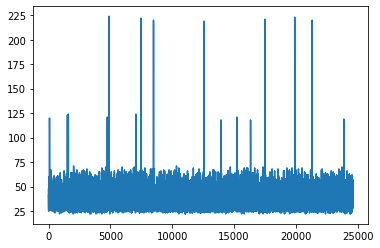

In [11]:
df_train['age'].plot()

print('Total number of rows having higher age: ', (df_train['age']>75).sum())

In [12]:
# Remove rows with age > 75
df_train.drop(df_train[df_train['age'] > 75].index, inplace = True) 

#### 3.1 Distribution of numerical features

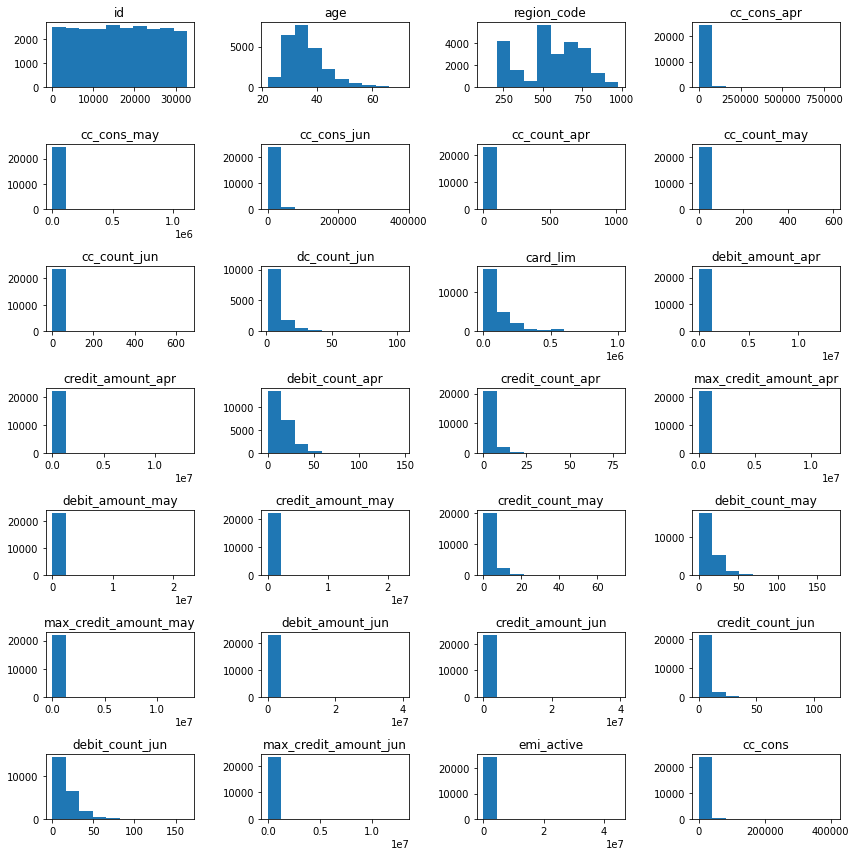

In [13]:
# Plot distribution of the numerical features
numeric_cols = df_train.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(7, 4, figsize=(12, 12))
ax = ax.flatten()

for i, col in enumerate(numeric_cols):
    ax[i].hist(df_train[col])
    ax[i].set_title(col)
    
plt.tight_layout()
plt.show()

***Insights:***
 - All the numerical features are highly positively skewed except id, age and region_code

#### 3.2 Check covariate shifts in dataset

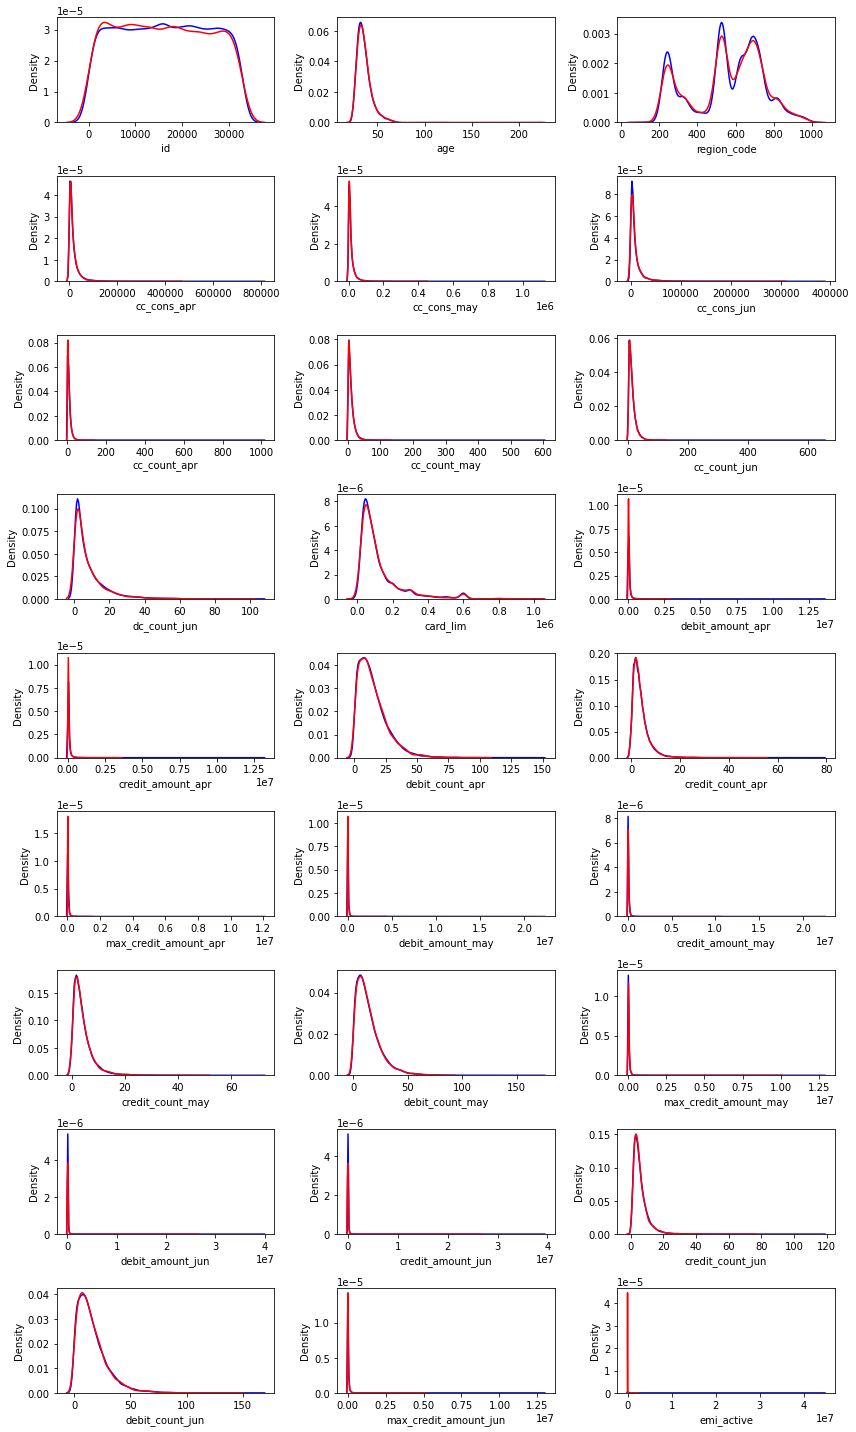

In [14]:
# Distribution of features from train and test
fig, ax = plt.subplots(9, 3, figsize=(12, 20))
ax = ax.flatten()

for i, icol in enumerate(numeric_cols[:-1]):
    sns.kdeplot(data=df_train, x=icol, color='b', ax=ax[i])
    sns.kdeplot(data=df_test, x=icol, color='r', ax=ax[i])
    
plt.tight_layout()
plt.show()

***Insights:***
 - From the above distribution plot, it seems pretty clear that there's no covariate shifts present in the dataset

#### 3.3 Impute null values

In [15]:
print(df_train.isnull().sum())

id                           0
account_type                 0
gender                       0
age                          0
region_code                  0
cc_cons_apr                  0
cc_cons_may                  0
cc_cons_jun                  0
cc_count_apr              1766
cc_count_may               858
cc_count_jun              1178
dc_count_jun             11652
card_lim                     6
debit_amount_apr          1426
credit_amount_apr         2518
debit_count_apr           1336
credit_count_apr          1336
max_credit_amount_apr     2518
debit_amount_may          1752
credit_amount_may         2565
credit_count_may          1574
debit_count_may           1574
max_credit_amount_may     2565
debit_amount_jun          1694
credit_amount_jun         1186
credit_count_jun          1172
debit_count_jun           1172
max_credit_amount_jun     1186
emi_active                   0
cc_cons                      0
dtype: int64


In [16]:
# Fill missing values with mean/median column values
imputed_median = df_train.median()

df_train.fillna(imputed_median, inplace=True)

In [17]:
df_train.isnull().sum()

id                       0
account_type             0
gender                   0
age                      0
region_code              0
cc_cons_apr              0
cc_cons_may              0
cc_cons_jun              0
cc_count_apr             0
cc_count_may             0
cc_count_jun             0
dc_count_jun             0
card_lim                 0
debit_amount_apr         0
credit_amount_apr        0
debit_count_apr          0
credit_count_apr         0
max_credit_amount_apr    0
debit_amount_may         0
credit_amount_may        0
credit_count_may         0
debit_count_may          0
max_credit_amount_may    0
debit_amount_jun         0
credit_amount_jun        0
credit_count_jun         0
debit_count_jun          0
max_credit_amount_jun    0
emi_active               0
cc_cons                  0
dtype: int64

### 4. Exploratory Data Analysis (EDA)

gender
F    7837.991198
M    6665.441192
Name: cc_cons, dtype: float64


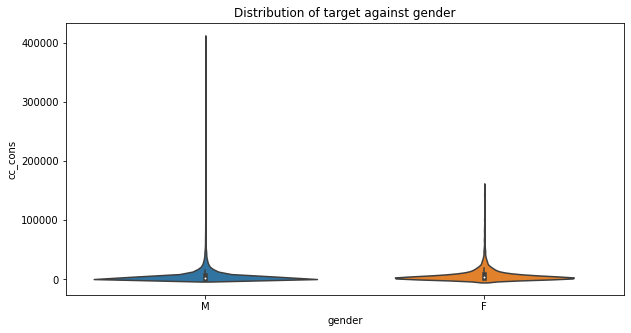

In [18]:
var = 'gender'
mean_data = df_train.groupby(var)['cc_cons'].mean()
print(mean_data)

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_train, x=var, y='cc_cons')
plt.title('Distribution of target against ' + var)
plt.show()

***Insights:***
 - Average Credit Card Spend is higher for male compare to female

account_type
current    6361.361222
saving     8573.591463
Name: cc_cons, dtype: float64


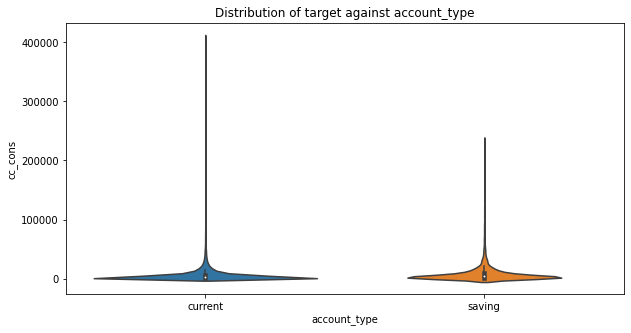

In [19]:
var = 'account_type'
mean_data = df_train.groupby(var)['cc_cons'].mean()
print(mean_data)

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_train, x=var, y='cc_cons')
plt.title('Distribution of target against ' + var)
plt.show()

***Insights:***
 - Average Credit Card Spend is higher for current accounts compare to saving accounts

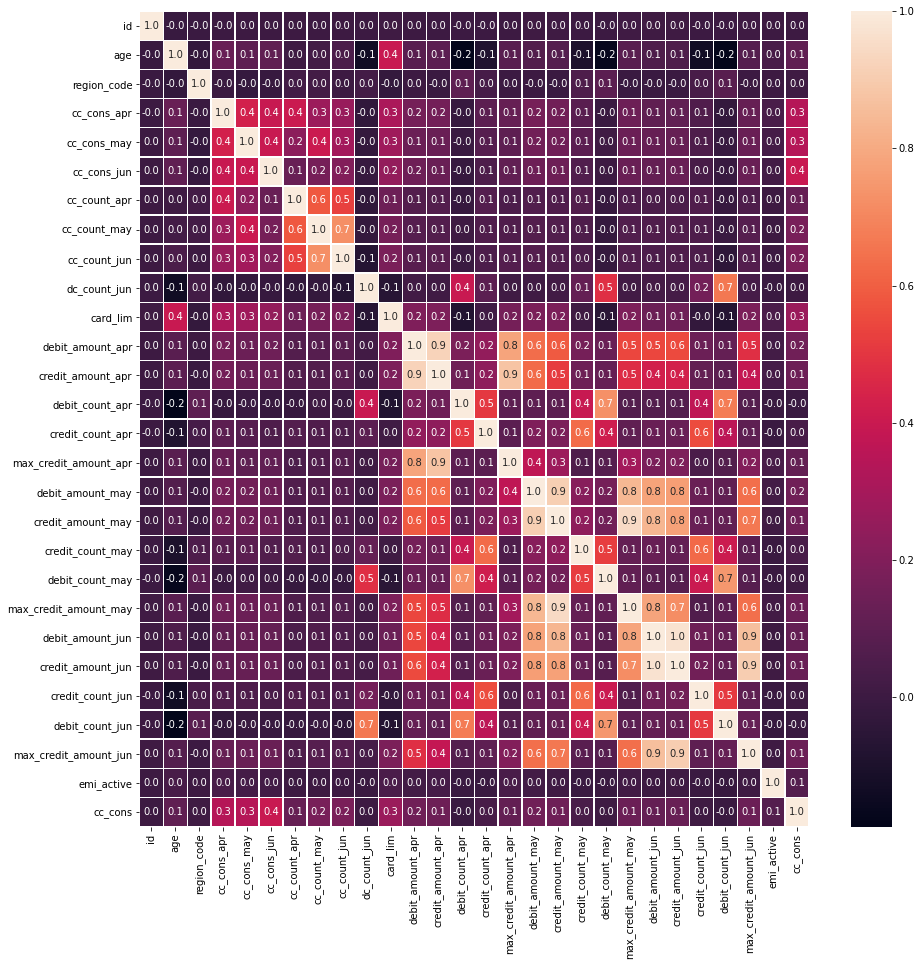

In [20]:
# Correlation map

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True, linewidths=0.5, fmt='.1f', ax=ax)
plt.show()

### 5. Feature Encoding

In [21]:
df_train['account_type'].value_counts()

current    19351
saving      5248
Name: account_type, dtype: int64

In [22]:
df_train['gender'].value_counts()

M    21077
F     3522
Name: gender, dtype: int64

In [23]:
le = LabelEncoder()

df_train['account_type'] = le.fit_transform(df_train['account_type'])
df_train['gender'] = le.fit_transform(df_train['gender'])

df_train[['account_type', 'gender']].head()

,account_type,gender
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


### 6. Model Building and Evaluating

#### 6.1 Custom Evaluation Metric

In [24]:
def RMSLE_100(y_true: pd.Series, y_pred: np.array) -> float:
    """
    Custom Root mean squared log error.
    
    Args:
        y_true (pd.Series): Actual values of target
        y_pred (np.array): Predicted values of target
    
    Returns:
        This function returns RMSLE*100
    """
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    
    return 100*rmsle

# Make custom scorer using RMSLE_100
rmsle_100_score = make_scorer(RMSLE_100, greater_is_better=False)

#### 6.2 Split data into train and validation

In [25]:
# Split the data

X = df_train.drop(columns=['id', 'cc_cons'])
y = df_train['cc_cons']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)

print(X_train.shape, X_val.shape)

(17219, 28) (7380, 28)


#### 6.3 Best model search using Grid Search Pipeline

In [26]:
pipeline = Pipeline([
    ('scaling', 'passthrough'),
    ('model', 'passthrough')
])

param_grid = {
    'scaling': [StandardScaler(), MinMaxScaler()],
    'model': [LinearRegression(), Ridge(), Lasso(), ElasticNet(), XGBRegressor(), RandomForestRegressor()]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=rmsle_100_score)

In [27]:
grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', 'passthrough'),
                                       ('model', 'passthrough')]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression(), Ridge(), Lasso(),
                                   ElasticNet(),
                                   XGBRegressor(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                gamma=None, gpu_id=None,
                                                importance_type='gain',
                                                interaction_constrai...
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estim

In [28]:
grid.best_estimator_

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('model', RandomForestRegressor())])

In [29]:
y_pred = grid.best_estimator_.predict(X_val)

print('Minimum predicted value: ', y_pred.min())
#y_pred[y_pred.argmin()] = 0.0

# Evaluate the 100*RMSLE
print('Training 100*RMSLE score: ', RMSLE_100(y_train, np.exp(grid.best_estimator_.predict(X_train)) - 1))
print('Validation 100*RMSLE score: ', RMSLE_100(y_val, np.exp(y_pred) - 1))

Minimum predicted value:  5.261181809173442
Training 100*RMSLE score:  44.26379677840838
Validation 100*RMSLE score:  117.63538819133342


### 7. Feature Selection and Hyperparameter Tuning

In [30]:
# from sklearn.feature_selection import RFECV

# clf_rf = RandomForestRegressor() 
# rfecv = RFECV(estimator=clf_rf, step=1, cv=5, scoring=rmsle_100_score, verbose=12)   # 5-fold cross-validation
# rfecv = rfecv.fit(X_train, np.log1p(y_train))

# print('Optimal number of features: ', rfecv.n_features_)
# print('Best features: \n', X.columns[rfecv.support_])

# X_rfecv_train = rfecv.transform(X_train)
# X_rfecv_val = rfecv.transform(X_val)

In [31]:
# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel('Number of features selected')
# plt.ylabel('Cross validation score of number of selected features')
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [32]:
# Feature Scaling
# Reference: https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(X_train.shape, X_val.shape)

(17219, 28) (7380, 28)


In [33]:
# Fit linear model and predict
# rfr = RandomForestRegressor()
# rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
#            max_features='sqrt', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#            min_samples_leaf=2, min_samples_split=5,
#            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
#            oob_score=False, random_state=None, verbose=0, warm_start=False)

rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

rfr.fit(X_train, np.log1p(y_train))

y_pred = rfr.predict(X_val)

# Evaluate the 100*RMSLE
print('Training 100*RMSLE score: ', RMSLE_100(y_train, np.exp(rfr.predict(X_train)) - 1))
print('Validation 100*RMSLE score: ', RMSLE_100(y_val, np.exp(y_pred) - 1))

Training 100*RMSLE score:  58.80018331744269
Validation 100*RMSLE score:  116.67618915677143


### 8. Test and create submission file

#### 8.1 Apply all the transformations to test data

In [34]:
ID = df_test['id'].copy()

# Remove null features
X_test = df_test.drop(null_cols.tolist() + ['id'], axis=1)

# Fill missing values with mean/median column values
X_test.fillna(imputed_median, inplace=True)

# Label encoding
X_test['account_type'] = le.fit_transform(X_test['account_type'])
X_test['gender'] = le.fit_transform(X_test['gender'])

# Feature Scaling
X_test = scaler.transform(X_test)

#### 8.2 Make predictions and prepare submission file

In [35]:
#y_pred = lr.predict(X_test)
# y_pred = grid.best_estimator_.predict(X_test)
y_pred = rfr.predict(X_test)

# Prepare dataframe with ID and target column
sumbission_df = pd.DataFrame()
sumbission_df['id'] = ID
sumbission_df['cc_cons'] = np.exp(y_pred) - 1
sumbission_df.head()

,id,cc_cons
0,16174,10502.834814
1,19966,2038.148471
2,18105,2819.215625
3,1201,1888.587856
4,1595,3649.780299


In [36]:
# Write Final predictions
sumbission_df.to_csv("./submission.csv", index=False)